# Psychological State Identification using Bayesian Networks
This notebook implements the Bayesian Network approach described in the project document
to classify psychological states (Stressed, Relaxed, Focused, Anxious) based on
simulated multimodal data from the [Kaggle dataset](https://www.kaggle.com/datasets/ziya07/psychological-state-identification-dataset).
# Methodology:
1. Load and preprocess the data.
2. Perform feature extraction and encoding.
3. Split data into training and testing sets.
4. Learn the Bayesian Network structure using Hill Climbing with BIC score.
5. Learn the parameters (CPDs) using Maximum Likelihood Estimation (MLE).
6. Perform inference on the test set using Variable Elimination.
7. Evaluate the model's classification performance.
8. Visualize the learned network structure.

## 1. Setup and Imports
Import necessary libraries. Ensure you have `pgmpy`, `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, and `networkx` installed.


In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.preprocessing import label_binarize

# pgmpy imports
from pgmpy.models import DiscreteBayesianNetwork # ImportError: BayesianNetwork has been deprecated. Please use DiscreteBayesianNetwork instead.
from pgmpy.estimators import HillClimbSearch, BIC, K2, MaximumLikelihoodEstimator, PC # BIC instead of BicScore, for some reason pgmpy docs are outdated wtf
from pgmpy.inference import VariableElimination

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 2. Data Loading and Initial Exploration

In [8]:
DATASET_PATH = 'simulated_psychological_data_v3.csv'
TARGET_VARIABLE = 'Psychological State'
TEST_SIZE = 0.20
RANDOM_STATE = 21 # for reproducibility
N_BINS = 5 # Number of bins for discretizing continuous features

# --- Load Data ---
try:
    df = pd.read_csv(DATASET_PATH)
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: Dataset file not found at {DATASET_PATH}")
    print("Please update the DATASET_PATH variable.")
    # Exit or raise error if file not found
    exit() # Or raise FileNotFoundError("Dataset file not found")

# Display basic info and first few rows
print("\nDataset Info:")
df.info()

print("\nFirst 5 rows:")
print(df.head())

# Check for missing values (as per document, none are expected in relevant columns)
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset loaded successfully.
Shape: (1000, 21)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Task Type                  1000 non-null   object 
 1   Cognitive Load             1000 non-null   object 
 2   Psychological State        1000 non-null   object 
 3   Ambient Noise (dB)         961 non-null    float64
 4   Heart Rate (BPM)           927 non-null    float64
 5   HRV (ms)                   957 non-null    float64
 6   GSR (μS)                   958 non-null    float64
 7   EEG_Delta                  939 non-null    float64
 8   EEG_Alpha                  953 non-null    float64
 9   EEG_Beta                   956 non-null    float64
 10  Skin Temp (°C)             942 non-null    float64
 11  BP_Systolic                950 non-null    float64
 12  Focus Duration (s)         947 non-null    

## 3. Data Preprocessing and Feature Engineering
- Extract features from 'EEG Power Bands' and 'Blood Pressure (mmHg)'.
- Drop columns not used for modeling ('ID', 'Time', 'Study Major').
- Encode categorical features using Label Encoding.

In [9]:
df_processed = df.copy() # Start with a fresh copy from Cell 2's loaded df

# --- Feature Extraction ---
print("\n--- Checking for Pre-extracted Features ---")
expected_extracted_cols = ['EEG_Delta', 'EEG_Alpha', 'EEG_Beta', 'BP_Systolic', 'BP_Diastolic']
# Check if these columns exist, if not, the simulation script might need to be run or dataset is different
for col_check in expected_extracted_cols:
    if col_check not in df_processed.columns:
        print(f"Warning: Expected pre-extracted column '{col_check}' not found. This might be okay if using a dataset without it.")
        # Create placeholder if absolutely necessary for downstream code, though ideally data should be correct
        # df_processed[col_check] = np.nan
if all(col in df_processed.columns for col in expected_extracted_cols):
    print("All expected pre-extracted features are present.")


# --- Identify Feature Types & Robust NaN/Inf Handling ---
print("\n--- Identifying Feature Types and Handling NaNs/Infs ---")
# TARGET_VARIABLE is 'Psychological State' (4 classes)

# Define all columns that *should* be numeric features
all_potential_numerical_features = [
    'HRV (ms)', 'GSR (μS)', 'EEG_Delta', 'EEG_Alpha', 'EEG_Beta',
    'BP_Systolic', 'BP_Diastolic', 'Oxygen Saturation (%)',
    'Heart Rate (BPM)', # Respiration Rate (BPM) is often categorical after binning in sim
    'Skin Temp (°C)', 'Ambient Noise (dB)', 'Ambient Light (lux)',
    'Room Temperature (°C)', 'Focus Duration (s)', 'Typing Speed (WPM)',
    'Click/Interaction Freq', 'Perceived Task Difficulty', 'Age'
]
# Filter this list to only those present in df_processed
numerical_cols_to_process = [col for col in all_potential_numerical_features if col in df_processed.columns]

print(f"Numerical columns targeted for to_numeric and NaN/Inf fill: {numerical_cols_to_process}")

for col in numerical_cols_to_process:
    # Convert to numeric, coercing errors (non-convertible to NaN)
    df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    # Replace infinities with NaN
    df_processed[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    # Fill NaNs (original, from coercion, or from Inf replacement)
    if df_processed[col].isnull().any():
        median_val = df_processed[col].median()
        if pd.isna(median_val): # Handle case where median is NaN (e.g., column is all NaNs)
            median_val = 0 # Default fill value if median can't be computed
            print(f"Warning: Median for '{col}' is NaN. Filling remaining NaNs with 0.")
        df_processed[col] = df_processed[col].fillna(median_val)
        print(f"Filled NaNs/Infs in numerical column '{col}' with: {median_val:.2f}")

# Identify final numerical and categorical columns after processing
final_numerical_cols = [col for col in df_processed.select_dtypes(include=np.number).columns if col != TARGET_VARIABLE]
all_feature_cols_set = set(df_processed.columns) - {TARGET_VARIABLE}
categorical_cols = sorted(list(all_feature_cols_set - set(final_numerical_cols)))

print(f"\nFinal numerical columns (for discretization): {final_numerical_cols}")
print(f"Final categorical columns (features): {categorical_cols}")

# Fill NaNs in categorical feature columns (if any) and the target column
for col in categorical_cols:
    if col in df_processed.columns and df_processed[col].isnull().any():
        df_processed[col] = df_processed[col].fillna('Missing_Cat_Value')
        print(f"Filled NaNs in categorical feature '{col}' with 'Missing_Cat_Value'")

if df_processed[TARGET_VARIABLE].isnull().any():
    df_processed[TARGET_VARIABLE] = df_processed[TARGET_VARIABLE].fillna('Unknown_Target_State')
    print(f"Filled NaNs in target '{TARGET_VARIABLE}' with 'Unknown_Target_State'")


# --- Data Splitting (BEFORE Discretization & Encoding of X) ---
X = df_processed.drop(TARGET_VARIABLE, axis=1)
y = df_processed[TARGET_VARIABLE]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
print(f"\nSplit data shapes: Train X={X_train.shape}, Test X={X_test.shape}")

# --- Discretization (Fit on Train, Transform Train & Test) ---
# Use final_numerical_cols identified after all processing and present in X_train
numerical_cols_for_discretization = [col for col in final_numerical_cols if col in X_train.columns]
print(f"\n--- Discretizing Numerical Features ({N_BINS} bins) ---")
print(f"Numerical columns for discretization: {numerical_cols_for_discretization}")

# Final check and fill for NaNs/Infs in the specific subset for discretization
for col in numerical_cols_for_discretization:
    # For X_train
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce') # Ensure numeric again
    X_train[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    if X_train[col].isnull().any():
        median_val_train = X_train[col].median()
        if pd.isna(median_val_train): median_val_train = 0
        print(f"Warning: NaNs/Infs found in X_train['{col}'] before discretization. Filling with train median: {median_val_train:.2f}")
        X_train[col] = X_train[col].fillna(median_val_train)
    # For X_test (using median from X_train to prevent data leakage)
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
    X_test[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    if X_test[col].isnull().any():
        # Use median calculated from X_train for X_test
        median_val_train_for_test = X_train[col].median() # Re-calculate on potentially cleaned X_train[col]
        if pd.isna(median_val_train_for_test): median_val_train_for_test = 0
        X_test[col] = X_test[col].fillna(median_val_train_for_test)


discretizer = KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='uniform', subsample=None, random_state=RANDOM_STATE)
if numerical_cols_for_discretization:
    # Ensure no NaNs or Infs before fitting
    if X_train[numerical_cols_for_discretization].isnull().values.any() or np.isinf(X_train[numerical_cols_for_discretization].values).any():
        print("CRITICAL ERROR: NaNs or Infs persist in X_train numerical columns before fitting discretizer. Please check data.")
        # You might want to raise an error here or implement a more robust fallback
    else:
        discretizer.fit(X_train[numerical_cols_for_discretization])
        X_train_num_discretized_vals = discretizer.transform(X_train[numerical_cols_for_discretization])
        X_test_num_discretized_vals = discretizer.transform(X_test[numerical_cols_for_discretization])

        X_train_num_discretized_df = pd.DataFrame(X_train_num_discretized_vals, columns=numerical_cols_for_discretization, index=X_train.index).astype(int)
        X_test_num_discretized_df = pd.DataFrame(X_test_num_discretized_vals, columns=numerical_cols_for_discretization, index=X_test.index).astype(int)

        X_train_processed = X_train.drop(columns=numerical_cols_for_discretization).join(X_train_num_discretized_df)
        X_test_processed = X_test.drop(columns=numerical_cols_for_discretization).join(X_test_num_discretized_df)
        print("Discretization complete.")
else:
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()
    print("No numerical columns found/left for discretization.")


# --- Encode ALL Features (Categorical + Discretized Numerical) and Target ---
print("\n--- Encoding All Features and Target ---")
label_encoders = {}

# Encode feature columns
for col in X_train_processed.columns:
    le = LabelEncoder()
    # Fit on combined data from this column in train and test to capture all possible values
    combined_X_col_data = pd.concat([X_train_processed[col].fillna('Missing_Encode').astype(str),
                                     X_test_processed[col].fillna('Missing_Encode').astype(str)], axis=0)
    le.fit(combined_X_col_data)
    X_train_processed[col] = le.transform(X_train_processed[col].fillna('Missing_Encode').astype(str))
    X_test_processed[col] = le.transform(X_test_processed[col].fillna('Missing_Encode').astype(str))
    label_encoders[col] = le
    print(f"Encoded feature column: {col}")

# Encode target variable (y_train, y_test)
le_target = LabelEncoder()
# Fit on combined y_train and y_test to capture all target classes
combined_y_data = pd.concat([y_train.fillna('Missing_Target_Encode').astype(str),
                             y_test.fillna('Missing_Target_Encode').astype(str)], axis=0)
le_target.fit(combined_y_data)
y_train_encoded = le_target.transform(y_train.fillna('Missing_Target_Encode').astype(str))
y_test_encoded = le_target.transform(y_test.fillna('Missing_Target_Encode').astype(str))
label_encoders[TARGET_VARIABLE] = le_target # Store encoder for the target
print(f"Encoded target column: {TARGET_VARIABLE}")
if len(le_target.classes_) <= 15: # Show mapping if not too many classes
    mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
    print(f"  Mapping for {TARGET_VARIABLE}: {mapping}")

# Combine encoded features and target for pgmpy
train_data = X_train_processed.join(pd.Series(y_train_encoded, name=TARGET_VARIABLE, index=X_train_processed.index))
test_data = X_test_processed.join(pd.Series(y_test_encoded, name=TARGET_VARIABLE, index=X_test_processed.index))

print("\nLabel Encoding complete.")
print("\nFinal Training Data (encoded first 5 rows):")
print(train_data.head())
print("\nFinal Training Data Info:")
train_data.info() # Check dtypes, should all be int or similar numeric for pgmpy




--- Checking for Pre-extracted Features ---
All expected pre-extracted features are present.

--- Identifying Feature Types and Handling NaNs/Infs ---
Numerical columns targeted for to_numeric and NaN/Inf fill: ['HRV (ms)', 'GSR (μS)', 'EEG_Delta', 'EEG_Alpha', 'EEG_Beta', 'BP_Systolic', 'BP_Diastolic', 'Heart Rate (BPM)', 'Skin Temp (°C)', 'Ambient Noise (dB)', 'Focus Duration (s)', 'Typing Speed (WPM)', 'Click/Interaction Freq', 'Perceived Task Difficulty', 'Age']
Filled NaNs/Infs in numerical column 'HRV (ms)' with: 47.43
Filled NaNs/Infs in numerical column 'GSR (μS)' with: 0.73
Filled NaNs/Infs in numerical column 'EEG_Delta' with: 11.74
Filled NaNs/Infs in numerical column 'EEG_Alpha' with: 7.80
Filled NaNs/Infs in numerical column 'EEG_Beta' with: 7.23
Filled NaNs/Infs in numerical column 'BP_Systolic' with: 117.12
Filled NaNs/Infs in numerical column 'BP_Diastolic' with: 90.47
Filled NaNs/Infs in numerical column 'Heart Rate (BPM)' with: 76.71
Filled NaNs/Infs in numerical col

## 4. Data Splitting (verification since splitting done above)
Split the encoded data into training (80%) and testing (20%) sets.


In [10]:
if 'train_data' not in locals() or 'test_data' not in locals():
    print("Error: train_data or test_data not defined. Please ensure Cell 3 has been run successfully.")
else:
    print(f"Final Training data shape: {train_data.shape}")
    print(f"Final Testing data shape: {test_data.shape}")

    # Verify target variable distribution in encoded data
    # TARGET_VARIABLE should be 'Psychological State' as per Cell 2's configuration
    if TARGET_VARIABLE in train_data.columns and TARGET_VARIABLE in test_data.columns:
        print(f"\nTarget '{TARGET_VARIABLE}' distribution in training data (encoded):")
        print(train_data[TARGET_VARIABLE].value_counts(normalize=True))
        print(f"\nTarget '{TARGET_VARIABLE}' distribution in testing data (encoded):")
        print(test_data[TARGET_VARIABLE].value_counts(normalize=True))
    else:
        print(f"Error: Target variable '{TARGET_VARIABLE}' not found in the processed train_data or test_data columns.")



Final Training data shape: (800, 21)
Final Testing data shape: (200, 21)

Target 'Psychological State' distribution in training data (encoded):
Psychological State
1    0.32750
3    0.30625
0    0.21750
2    0.14875
Name: proportion, dtype: float64

Target 'Psychological State' distribution in testing data (encoded):
Psychological State
1    0.325
3    0.305
0    0.220
2    0.150
Name: proportion, dtype: float64


## 5. Bayesian Network Structure Learning
Learn the DAG structure from the training data using the Hill Climbing search algorithm and BIC score.


In [12]:
print("Starting structure learning (this may take some time)...")

# Initialize scoring method and search algorithm
# bic_scorer = BIC(data=train_data)
scorer = BIC(data=train_data)
hc = HillClimbSearch(data=train_data)

# Perform the search
# `max_indegree` can be used to limit complexity if needed
# Ensure all data is integer type for estimators
train_data = train_data.astype(int)
best_model_structure = hc.estimate(
    scoring_method=scorer, # Pass the BIC instance
    # max_indegree=None, # Optional: Limit parent count per node
    # black_list=None, # Optional: Prevent specific edges
    # white_list=None, # Optional: Force specific edges
    show_progress=True # Set to False to hide progress bar if running non-interactively
)
print(f"Learned Edges: {list(best_model_structure.edges())}")

print("\nStructure learning complete.")
print(f"Learned Edges ({len(best_model_structure.edges())}):")
# Print edges for inspection (can be numerous)
# print(sorted(list(best_model_structure.edges())))

# Create the Bayesian Network model with the learned structure
model = DiscreteBayesianNetwork(best_model_structure.edges())
model.add_nodes_from(train_data.columns) # Ensure all nodes are included

print(f"\nModel nodes ({len(model.nodes())}): {model.nodes()}")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Task Type': 'N', 'Cognitive Load': 'N', 'Respiration Rate (BPM)': 'N', 'Gender': 'N', 'Educational Level': 'N', 'Ambient Noise (dB)': 'N', 'Heart Rate (BPM)': 'N', 'HRV (ms)': 'N', 'GSR (μS)': 'N', 'EEG_Delta': 'N', 'EEG_Alpha': 'N', 'EEG_Beta': 'N', 'Skin Temp (°C)': 'N', 'BP_Systolic': 'N', 'Focus Duration (s)': 'N', 'BP_Diastolic': 'N', 'Age': 'N', 'Perceived Task Difficulty': 'N', 'Click/Interaction Freq': 'N', 'Typing Speed (WPM)': 'N', 'Psychological State': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Task Type': 'N', 'Cognitive Load': 'N', 'Respiration Rate (BPM)': 'N', 'Gender': 'N', 'Educational Level': 'N', 'Ambient Noise (dB)': 'N', 'Heart Rate (BPM)': 'N', 'HRV (ms)': 'N', 'GSR (μS)': 'N', 'EEG_Delta': 'N', 'EEG_Alpha': 'N', 'EEG_Beta': 'N', 'Skin Temp (°C)': 'N', 'BP_Systolic': 'N', 'Focus Duration (s

Starting structure learning (this may take some time)...


  0%|          | 0/1000000 [00:00<?, ?it/s]

Learned Edges: [('Cognitive Load', 'EEG_Delta'), ('Cognitive Load', 'EEG_Alpha'), ('Cognitive Load', 'GSR (μS)'), ('Cognitive Load', 'EEG_Beta'), ('Cognitive Load', 'HRV (ms)'), ('Cognitive Load', 'Focus Duration (s)'), ('Cognitive Load', 'BP_Diastolic'), ('Cognitive Load', 'Heart Rate (BPM)'), ('Cognitive Load', 'Typing Speed (WPM)'), ('Cognitive Load', 'Psychological State'), ('Cognitive Load', 'Skin Temp (°C)'), ('Cognitive Load', 'BP_Systolic'), ('Cognitive Load', 'Task Type'), ('Respiration Rate (BPM)', 'Cognitive Load')]

Structure learning complete.
Learned Edges (14):

Model nodes (21): ['Cognitive Load', 'EEG_Delta', 'EEG_Alpha', 'GSR (μS)', 'EEG_Beta', 'HRV (ms)', 'Focus Duration (s)', 'BP_Diastolic', 'Heart Rate (BPM)', 'Typing Speed (WPM)', 'Psychological State', 'Skin Temp (°C)', 'BP_Systolic', 'Task Type', 'Respiration Rate (BPM)', 'Gender', 'Educational Level', 'Ambient Noise (dB)', 'Age', 'Perceived Task Difficulty', 'Click/Interaction Freq']


## 6. Bayesian Network Parameter Learning
Estimate the Conditional Probability Distributions (CPDs) for each node in the learned structure using Maximum Likelihood Estimation (MLE) on the training data.


In [18]:
print("Starting parameter learning (MLE)...")

# Fit the model using MLE
# state_names can be provided if LabelEncoder wasn't used, but it should infer from data
model.fit(
    data=train_data,
    estimator=MaximumLikelihoodEstimator
    # state_names={col: list(label_encoders[col].classes_) for col in categorical_cols if col in label_encoders} # Optional: provide explicit names
)

print("Parameter learning complete.")

# --- Model Validation (Basic Checks) ---
print("\nChecking model structure and parameters...")
try:
    model.check_model()
    print("Model check successful: Structure is valid and CPDs sum to 1.")
except Exception as e:
    print(f"Model check failed: {e}")

# Optionally, print a few CPDs to inspect
print("\nExample CPDs (first 3):")
cpd_count = 0
for cpd in model.get_cpds()[:3]:
    print(f"\nCPD for variable: {cpd.variable}")
    print(cpd)
    cpd_count += 1
if cpd_count == 0:
    print("No CPDs found (check fitting process).")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Task Type': 'N', 'Cognitive Load': 'N', 'Respiration Rate (BPM)': 'N', 'Gender': 'N', 'Educational Level': 'N', 'Ambient Noise (dB)': 'N', 'Heart Rate (BPM)': 'N', 'HRV (ms)': 'N', 'GSR (μS)': 'N', 'EEG_Delta': 'N', 'EEG_Alpha': 'N', 'EEG_Beta': 'N', 'Skin Temp (°C)': 'N', 'BP_Systolic': 'N', 'Focus Duration (s)': 'N', 'BP_Diastolic': 'N', 'Age': 'N', 'Perceived Task Difficulty': 'N', 'Click/Interaction Freq': 'N', 'Typing Speed (WPM)': 'N', 'Psychological State': 'N'}


Starting parameter learning (MLE)...
Parameter learning complete.

Checking model structure and parameters...
Model check successful: Structure is valid and CPDs sum to 1.

Example CPDs (first 3):

CPD for variable: Cognitive Load
+------------------------+-----+---------------------------+
| Respiration Rate (BPM) | ... | Respiration Rate (BPM)(3) |
+------------------------+-----+---------------------------+
| Cognitive Load(0)      | ... | 0.425531914893617         |
+------------------------+-----+---------------------------+
| Cognitive Load(1)      | ... | 0.2765957446808511        |
+------------------------+-----+---------------------------+
| Cognitive Load(2)      | ... | 0.2978723404255319        |
+------------------------+-----+---------------------------+

CPD for variable: EEG_Delta
+----------------+-----+--------------------+
| Cognitive Load | ... | Cognitive Load(2)  |
+----------------+-----+--------------------+
| EEG_Delta(0)   | ... | 0.0                |
+------

## 7. Inference and Prediction on Test Set
Use the learned model to predict the psychological state for each instance in the test set. We use the Variable Elimination algorithm for exact inference.


In [14]:
print("Starting inference on the test set...")

# Prepare test data for prediction (remove target variable)
X_test_encoded = test_data.drop(columns=[TARGET_VARIABLE])
y_test_encoded = test_data[TARGET_VARIABLE] # Keep encoded target for evaluation

# Initialize inference engine
inference_engine = VariableElimination(model)

# Predict probabilities for each class
y_pred_probs = None 
y_pred_labels_encoded = []

# Store original decoded labels for final report
y_test_labels = label_encoders[TARGET_VARIABLE].inverse_transform(y_test_encoded)


# Attempt batch prediction (should work better with discrete data)
try:
    print("Attempting batch prediction...")
    # Ensure columns match the order expected by the model
    X_test_encoded = X_test_encoded[list(X_train_processed.columns)] # Ensure same column order as training

    # Predict most likely state (encoded)
    y_pred_encoded_df = model.predict(X_test_encoded, n_jobs=-1)
    y_pred_labels_encoded = y_pred_encoded_df[TARGET_VARIABLE].values

    # Predict probabilities
    print("Predicting probabilities...")
    y_pred_probs_df = model.predict_probability(X_test_encoded, n_jobs=-1)

    # Ensure probability columns are in the correct order of original classes
    ordered_classes_encoded = label_encoders[TARGET_VARIABLE].transform(label_encoders[TARGET_VARIABLE].classes_)
    prob_cols_ordered = [f"{TARGET_VARIABLE}_{enc_val}" for enc_val in sorted(ordered_classes_encoded)] # pgmpy uses TARGET_encodedvalue

    # Check if columns exist and extract in correct order
    available_cols = y_pred_probs_df.columns.tolist()
    cols_to_use = [col for col in prob_cols_ordered if col in available_cols]
    missing_cols = [col for col in prob_cols_ordered if col not in available_cols]

    if missing_cols:
        print(f"Warning: Expected probability columns missing: {missing_cols}")
        # Handle missing columns if necessary (e.g., assign zero probability)
        # For simplicity, we'll proceed with available columns, but AUC might be affected
        y_pred_probs = y_pred_probs_df[cols_to_use].values
        # Need to ensure y_pred_probs has the right shape for roc_auc_score later
        # Pad with zeros for missing classes if needed (complex to get right order)
        # For now, set to None to skip AUC if columns are missing
        print("Setting probabilities to None due to missing columns.")
        y_pred_probs = None

    else:
         y_pred_probs = y_pred_probs_df[cols_to_use].values

    print("Batch prediction successful.")

except Exception as e:
    print(f"An unexpected error occurred during batch prediction ({e}), falling back to row-by-row inference (slower)...")
    # Fallback code
    y_pred_probs_list = []
    y_pred_labels_encoded = [] # Store encoded labels first
    for index, row in X_test_encoded.iterrows():
        try:
            evidence = row.to_dict()
            # Ensure evidence values are integers
            evidence = {k: int(v) for k, v in evidence.items()}
            prob_dist = inference_engine.query(variables=[TARGET_VARIABLE], evidence=evidence, show_progress=False)
            probs = prob_dist.values
            predicted_state_encoded = np.argmax(probs)
            y_pred_labels_encoded.append(predicted_state_encoded)
            y_pred_probs_list.append(probs)
        except Exception as query_error:
            print(f"Error during inference for row {index}: {query_error}")
            y_pred_labels_encoded.append(np.nan) # Use NaN for error
            num_classes = len(label_encoders[TARGET_VARIABLE].classes_)
            y_pred_probs_list.append([np.nan] * num_classes) # Placeholder probs

    y_pred_probs = np.array(y_pred_probs_list)
    y_pred_labels_encoded = np.array(y_pred_labels_encoded) # Convert list to array


print("Inference complete.")

# Decode predicted labels (handle potential NaNs from errors)
valid_preds_indices = ~np.isnan(y_pred_labels_encoded)
y_pred_labels = np.full(len(y_test_labels), fill_value='Error', dtype=object) # Initialize with placeholder
if np.any(valid_preds_indices):
     valid_preds_encoded = y_pred_labels_encoded[valid_preds_indices].astype(int)
     y_pred_labels[valid_preds_indices] = label_encoders[TARGET_VARIABLE].inverse_transform(valid_preds_encoded)

# print(f"First 5 predictions (decoded): {y_pred_labels[:5]}")
# print(f"First 5 actual labels (decoded): {y_test_labels[:5]}")

Starting inference on the test set...
Attempting batch prediction...


  0%|          | 0/200 [00:00<?, ?it/s]

Predicting probabilities...
An unexpected error occurred during batch prediction (DiscreteBayesianNetwork.predict_probability() got an unexpected keyword argument 'n_jobs'), falling back to row-by-row inference (slower)...
Inference complete.


## 8. Model Evaluation
Evaluate the classifier's performance using accuracy, classification report (precision, recall, F1-score), confusion matrix, and AUC (Area Under the ROC Curve) on the **encoded and discretized** data.


Evaluating model performance...

Overall Accuracy: 0.5300

Classification Report:
              precision    recall  f1-score   support

     Anxious       0.00      0.00      0.00        44
     Focused       0.54      0.58      0.56        65
     Relaxed       0.62      1.00      0.77        30
    Stressed       0.47      0.62      0.54        61

    accuracy                           0.53       200
   macro avg       0.41      0.55      0.47       200
weighted avg       0.41      0.53      0.46       200


Confusion Matrix:
[[ 0 10  0 34]
 [ 0 38 18  9]
 [ 0  0 30  0]
 [ 0 23  0 38]]


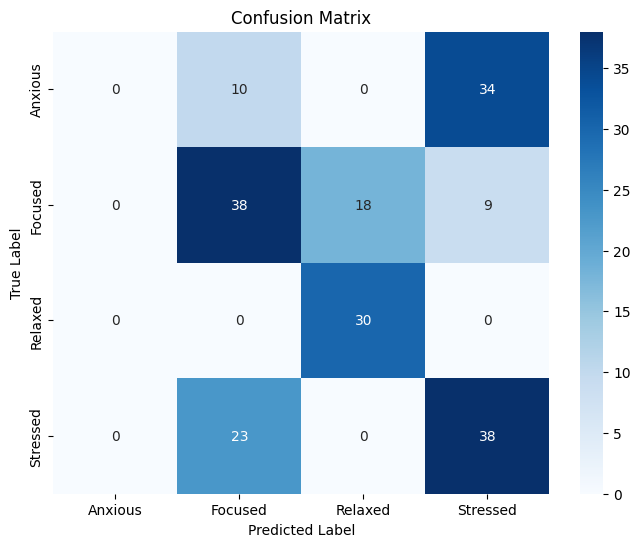


AUC Score (Micro Average, OvR): 0.8253
AUC Score (Macro Average, OvR): 0.7920


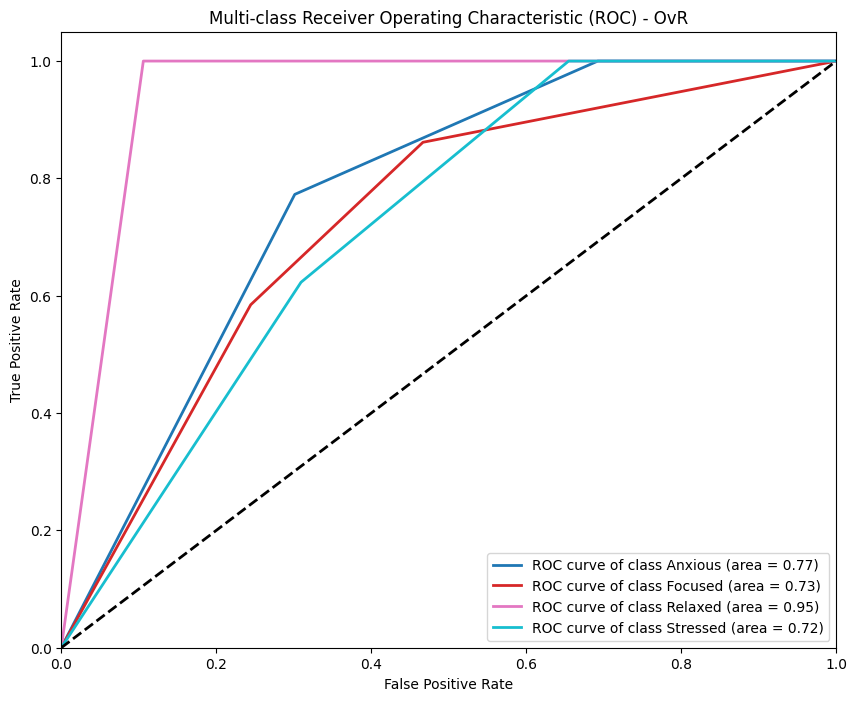

In [15]:
print("Evaluating model performance...")

# Filter out any instances where prediction failed (resulted in 'Error' or NaN)
valid_comparison_indices = (y_pred_labels != 'Error')
y_test_labels_filtered = y_test_labels[valid_comparison_indices]
y_pred_labels_filtered = y_pred_labels[valid_comparison_indices]
y_test_encoded_filtered = y_test_encoded[valid_comparison_indices] # Get corresponding encoded true labels

# Filter probabilities array if it exists and matches length
if y_pred_probs is not None and y_pred_probs.shape[0] == len(valid_comparison_indices):
     # Filter NaNs that might have occurred during row-by-row fallback
     prob_valid_indices = ~np.isnan(y_pred_probs).any(axis=1)
     combined_valid = valid_comparison_indices & prob_valid_indices

     y_pred_probs_filtered = y_pred_probs[combined_valid]
     # Also re-filter labels based on valid probabilities
     y_test_labels_filtered = y_test_labels[combined_valid]
     y_pred_labels_filtered = y_pred_labels[combined_valid]
     y_test_encoded_filtered = y_test_encoded[combined_valid]
else:
     y_pred_probs_filtered = None # Indicate probabilities are unavailable/mismatched
     print("Warning: Probabilities array issue detected. AUC calculation might be skipped.")


if len(y_test_labels_filtered) == 0:
    print("Error: No valid predictions available for evaluation.")
else:
    # --- Accuracy ---
    accuracy = accuracy_score(y_test_labels_filtered, y_pred_labels_filtered)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # --- Classification Report ---
    print("\nClassification Report:")
    # Use the actual labels present in the filtered results for the report
    report_labels = sorted(list(set(y_test_labels_filtered) | set(y_pred_labels_filtered)))
    print(classification_report(y_test_labels_filtered, y_pred_labels_filtered, labels=report_labels, target_names=report_labels, zero_division=0))

    # --- Confusion Matrix ---
    print("\nConfusion Matrix:")
    # Ensure labels for CM are consistent with report_labels
    cm = confusion_matrix(y_test_labels_filtered, y_pred_labels_filtered, labels=report_labels)
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=report_labels, yticklabels=report_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # --- AUC (Area Under the ROC Curve) ---
    n_classes = len(report_labels)
    if n_classes > 1 and y_pred_probs_filtered is not None and y_pred_probs_filtered.shape[0] == len(y_test_encoded_filtered):
        try:
            # Binarize the true labels based on the classes present in the results
            binarizer_classes_encoded = label_encoders[TARGET_VARIABLE].transform(report_labels)
            y_test_binarized = label_binarize(y_test_encoded_filtered, classes=binarizer_classes_encoded)

            # Ensure probabilities match the binarized shape
            if y_test_binarized.shape[1] != y_pred_probs_filtered.shape[1]:
                 print(f"Warning: Shape mismatch between binarized labels ({y_test_binarized.shape}) and probabilities ({y_pred_probs_filtered.shape}). Skipping AUC.")
                 # This can happen if batch probability prediction failed and returned fewer columns
            elif n_classes == 2:
                 # Binary case: Use probability of the positive class
                 positive_class_index = 1 # Index corresponding to the second class in report_labels
                 y_pred_probs_auc = y_pred_probs_filtered[:, positive_class_index]
                 auc_score = roc_auc_score(y_test_binarized.ravel(), y_pred_probs_auc)
                 print(f"\nAUC Score (Binary Case): {auc_score:.4f}")
                 fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_pred_probs_auc)
                 plt.figure(figsize=(7, 5))
                 plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
                 plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                 plt.xlim([0.0, 1.0])
                 plt.ylim([0.0, 1.05])
                 plt.xlabel('False Positive Rate')
                 plt.ylabel('True Positive Rate')
                 plt.title('Receiver Operating Characteristic (ROC) Curve')
                 plt.legend(loc="lower right")
                 plt.show()

            elif n_classes > 2:
                 # Multi-class case: Calculate OvR AUC scores
                 auc_micro = roc_auc_score(y_test_binarized, y_pred_probs_filtered, average='micro', multi_class='ovr')
                 auc_macro = roc_auc_score(y_test_binarized, y_pred_probs_filtered, average='macro', multi_class='ovr')
                 print(f"\nAUC Score (Micro Average, OvR): {auc_micro:.4f}")
                 print(f"AUC Score (Macro Average, OvR): {auc_macro:.4f}")

                 # Plot ROC curve for each class
                 fpr = dict()
                 tpr = dict()
                 roc_auc = dict()
                 plt.figure(figsize=(10, 8))
                 colors = plt.cm.get_cmap('tab10', n_classes) # Get distinct colors

                 for i, class_label in enumerate(report_labels):
                     fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs_filtered[:, i])
                     roc_auc[i] = auc(fpr[i], tpr[i])
                     plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'ROC curve of class {class_label} (area = {roc_auc[i]:.2f})')

                 plt.plot([0, 1], [0, 1], 'k--', lw=2)
                 plt.xlim([0.0, 1.0])
                 plt.ylim([0.0, 1.05])
                 plt.xlabel('False Positive Rate')
                 plt.ylabel('True Positive Rate')
                 plt.title('Multi-class Receiver Operating Characteristic (ROC) - OvR')
                 plt.legend(loc="lower right")
                 plt.show()

        except ValueError as ve:
             print(f"\nCould not calculate AUC due to ValueError: {ve}")
             print("  This often happens if only one class is present in the test labels after filtering, or if probabilities are malformed.")
        except Exception as e:
            print(f"\nCould not calculate AUC due to unexpected error: {e}")

    else:
        print("\nAUC calculation skipped.")
        if n_classes <= 1: print("  Reason: Not enough classes present in results.")
        if y_pred_probs_filtered is None: print("  Reason: Probabilities were not generated or available/valid.")
        elif y_pred_probs_filtered.shape[0] != len(y_test_encoded_filtered): print(f"  Reason: Mismatched shapes - Probs: {y_pred_probs_filtered.shape[0]}, Filtered Labels: {len(y_test_encoded_filtered)}")

## 9. Visualize Learned Network Structure
Display the learned Directed Acyclic Graph (DAG).


Visualizing learned network structure...
Using graphviz layout (neato).


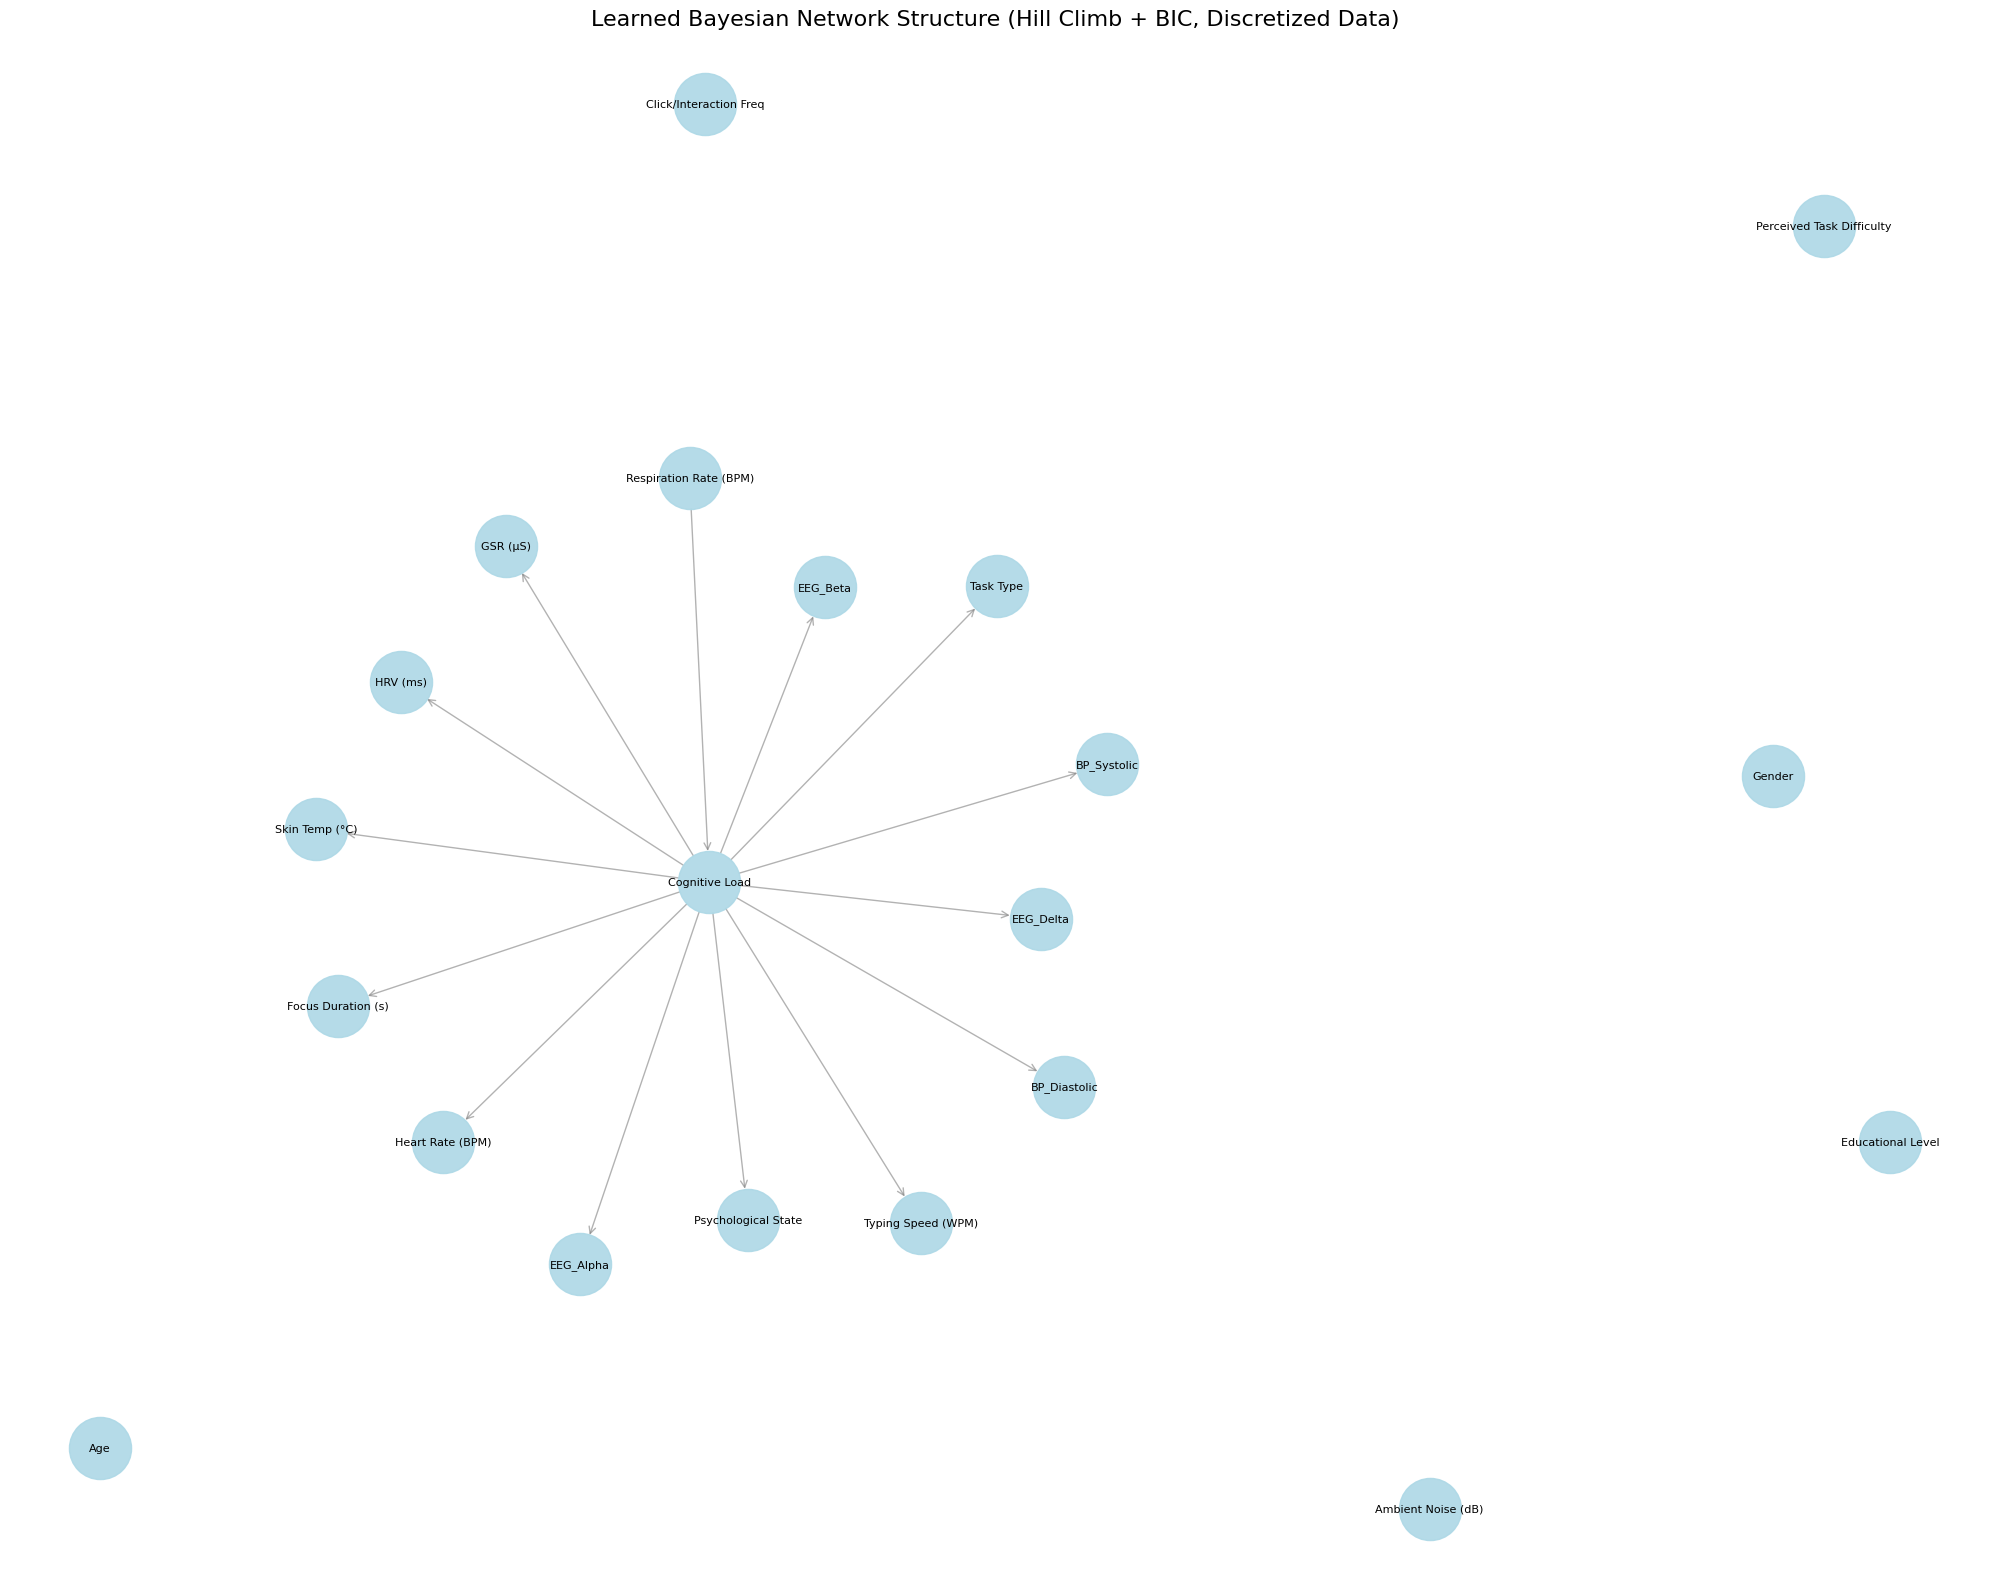

Visualization complete.


In [16]:
print("\nVisualizing learned network structure...")

plt.figure(figsize=(20, 16)) # Increased size for potentially more nodes/edges
try:
    # Use a layout algorithm that handles larger graphs better
    # Requires graphviz and pygraphviz/pydot: `pip install pygraphviz` or `pip install pydot`
    pos = nx.nx_agraph.graphviz_layout(model, prog='neato')
    print("Using graphviz layout (neato).")
except ImportError:
    print("Graphviz/pygraphviz/pydot not found, using alternative layout (kamada_kawai). Install graphviz and pygraphviz or pydot for potentially better layouts.")
    pos = nx.kamada_kawai_layout(model)
except Exception as layout_err:
     print(f"Layout failed ({layout_err}), using basic spring layout.")
     pos = nx.spring_layout(model)


# Draw nodes
nx.draw_networkx_nodes(model, pos, node_size=2000, node_color='lightblue', alpha=0.9)

# Draw edges
nx.draw_networkx_edges(model, pos, edgelist=model.edges(), arrowstyle='->', arrowsize=12, edge_color='gray', alpha=0.6, node_size=2000) # Match node_size

# Draw labels
nx.draw_networkx_labels(model, pos, font_size=8) # Adjusted font size

plt.title("Learned Bayesian Network Structure (Hill Climb + BIC, Discretized Data)", fontsize=16)
plt.axis('off') # Turn off the axis
plt.tight_layout()
plt.show()

print("Visualization complete.")